In [26]:
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

In [27]:
ARTIFACT_DIR = "artifact/"
csv_file = 'data/full_emoji.csv'
data = pd.read_csv(csv_file)
data.sample(n=5)

,#,emoji,unicode,name,Apple,Google,Facebook,Windows,Twitter,JoyPixels,Samsung,Gmail,SoftBank,DoCoMo,KDDI
1387,1388,♉,U+2649,Taurus,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDwAPAIABAP9mAP//...","data:image/png;base64,R0lGODlhDwAPAKIAAL8kr//O...","data:image/png;base64,R0lGODlhDAAMAIABAP+ZAP//...","data:image/png;base64,R0lGODlhDgAPALMKAGYAAJlm..."
1629,1630,🇫🇮,U+1F1EB U+1F1EE,flag: Finland,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,NaN,NaN,NaN
1130,1131,🔕,U+1F515,bell with slash,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,NaN,NaN,NaN
827,828,⛲,U+26F2,fountain,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDwAPALMPAGFgYDEE...","data:image/png;base64,R0lGODlhDwAPALMAAP9vAACc...",NaN,"data:image/png;base64,R0lGODlhDgAPALMJADMzmQD/..."
949,950,🌔,U+1F314,waxing gibbous moon,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDwAPALMPAP//AFFR...",NaN,"data:image/png;base64,R0lGODlhDAAMAJECAAAAAP//...","data:image/png;base64,R0lGODlhDgAPAKIEAMzMmTMz..."


In [28]:
def save_plot(filename: str) -> None:
    out_path = os.path.join(ARTIFACT_DIR, os.path.basename(filename))
    plt.savefig(out_path, dpi=300, bbox_inches='tight')

def plot_weight_distributions(model, title):
    weight_params = [param for name, param in model.named_parameters() if 'weight' in name]
    num_weights = len(weight_params)
    num_cols = 4
    num_rows = math.ceil(num_weights / num_cols)

    plt.figure(figsize=(15, num_rows * 5))

    for i, param in enumerate(weight_params):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.hist(param.cpu().data.numpy().flatten(), bins=50)
        plt.title(f'Layer {i + 1} weights')

    plt.suptitle(title)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    save_plot(f"{title}.png")
    plt.close()

def plot_loss_vs_epoch(lossG_list, lossD_real_list, lossD_fake_list, total_loss_list):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss vs Epoch")
    plt.plot(lossG_list, label="G")
    plt.plot(lossD_real_list, label="D Real")
    plt.plot(lossD_fake_list, label="D Fake")
    plt.plot(total_loss_list, label="Total Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    save_plot("losses_vs_epoch.png")
    plt.close()

In [29]:
class EmojiDataset(Dataset):
    def __init__(self, img_dirs, csv_file, transform=None):
        self.img_dirs = img_dirs
        self.data = pd.read_csv(csv_file)
        
        # Filter the dataset to include only face emojis
        self.data = self.data[self.data['name'].str.contains('face', case=False, na=False)].reset_index(drop=True)        
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, f'{img_id}.png')
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f'Image with ID {img_id} not found in any of the specified directories.')

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [30]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

img_dirs = [
    'data/image/Apple',
    'data/image/DoCoMo',
    'data/image/Facebook',
    'data/image/Gmail',
    'data/image/Google',
    'data/image/JoyPixels',
    'data/image/KDDI',
    'data/image/Samsung',
    'data/image/SoftBank',
    'data/image/Twitter',
    'data/image/Windows'
]
csv_file = 'data/full_emoji.csv'
dataset = EmojiDataset(img_dirs, csv_file, transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [31]:
# Hyperparameters
batch_size = 32
image_size = 64
nc = 3  # CHANNELS
nz = 256  # INPUT DIM (noise)
ngf = 256  # GENERATOR feature map size
ndf = 64  # DISCRIMINATOR feature map size
lrD = 0.0001
lrG = 0.001
beta1 = 0.5
beta2 = 0.999
clip_value = 0.75
d_update_period = 3


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [32]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the generator and discriminator
netG = Generator().to(device)
netG.apply(weights_init)

netD = Discriminator().to(device)
netD.apply(weights_init)

# Loss function and optimizers
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 0.999
fake_label = 0.001

optimizerD = optim.AdamW(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.AdamW(netG.parameters(), lr=lrG, betas=(beta1, 0.999))


Epoch [600/600]
	Loss D Real:	0.4936659336090088
	Loss D Fake:	0.6857096552848816
	Loss D Total:	1.1793755888938904
	Loss G:	0.9893777370452881
	Loss Total:	2.1687533259391785


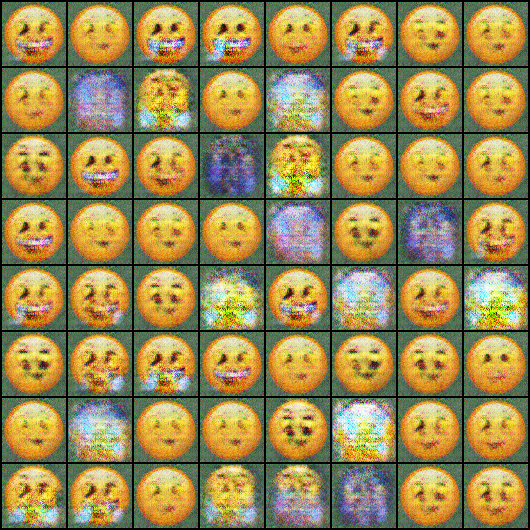

In [33]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython.display import clear_output, display

lossG_list = []
lossD_real_list = []
lossD_fake_list = []
total_loss_list = []

num_epochs = 600
schedulerD = ReduceLROnPlateau(optimizerD, mode='min', factor=0.99, patience=4)
schedulerG = ReduceLROnPlateau(optimizerG, mode='min', factor=0.99, patience=4)


for epoch in range(num_epochs):
    lossD_real = -1
    lossD_fake = -1
    lossG = -1
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator with real data
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()
        # Update Discriminator with fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        lossD = lossD_real + lossD_fake
        nn.utils.clip_grad_norm_(netD.parameters(), clip_value)
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        nn.utils.clip_grad_norm_(netG.parameters(), clip_value)
        optimizerG.step()
    
    # Save generated images for impactful display.
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()
    
    # Step the learning rate schedulers
    schedulerD.step(lossD)
    schedulerG.step(lossG)
    
    # Store losses so we can make nice plots.
    lossG_list.append(lossG.item())
    lossD_real_list.append(lossD_real.item())
    lossD_fake_list.append(lossD_fake.item())
    total_loss_list.append(lossD_real.item() + lossD_fake.item() + lossG.item())

    clear_output()
    img_epoch = (epoch+1) if (epoch+1) % 100 == 0 else "latest"
    save_image(fake_images, f'artifact/generated/epoch_{img_epoch}.png', normalize=True)
    print(f'Epoch [{epoch+1}/{num_epochs}]\n\t'
              f'Loss D Real:\t{lossD_real.item()}\n\t'
              f'Loss D Fake:\t{lossD_fake.item()}\n\t'
              f'Loss D Total:\t{lossD_real.item() + lossD_fake.item()}\n\t'
              f'Loss G:\t{lossG.item()}\n\t'
              f'Loss Total:\t{lossD_real.item() + lossD_fake.item() + lossG.item()}')
    display(Image.open(f'artifact/generated/epoch_{img_epoch}.png'))
    if (epoch+1) % 25 == 0 or epoch == num_epochs - 1:
        plot_loss_vs_epoch(lossG_list, lossD_real_list, lossD_fake_list, total_loss_list)
plot_loss_vs_epoch(lossG_list, lossD_real_list, lossD_fake_list, total_loss_list)
plot_weight_distributions(netG, 'Generator Weight Distributions')
plot_weight_distributions(netD, 'Discriminator Weight Distributions')